In [1]:
# ===========================================
# Photon timeline generator (1.5×R90 region)
# ===========================================
import os
import glob
import warnings
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u


# ------------------------------------------------
# Empirical Chandra PSF R90 from off-axis angle
# ------------------------------------------------
def estimate_R90(ra_deg, dec_deg, hdr):
    """Empirical Chandra PSF R90 (arcsec) from off-axis angle (arcmin)."""
    ra_pnt, dec_pnt = hdr.get("RA_PNT"), hdr.get("DEC_PNT")
    if ra_pnt is None or dec_pnt is None:
        return 1.0
    src = SkyCoord(ra_deg, dec_deg, unit="deg")
    pnt = SkyCoord(ra_pnt, dec_pnt, unit="deg")
    theta = src.separation(pnt).arcmin
    return 0.31 + 0.13 * theta + 0.020 * theta**2


# ------------------------------------------------
# Generate photon-by-photon timeline table
# ------------------------------------------------
def generate_photon_timeline(evtfile, ra, dec, obsid=None, significance=None):
    """
    Create a photon-by-photon table inside 1.5×R90 of the source position.
    Includes photon times (UTC + relative), energies, and positions (RA/DEC/X/Y).
    Uses correct Chandra time reference and sky WCS.
    """
    outdir_tbl = "detections/photon_tables"
    os.makedirs(outdir_tbl, exist_ok=True)

    # --- Load event data ---
    with fits.open(evtfile) as hdul:
        events_hdu = hdul["EVENTS"] if "EVENTS" in hdul else hdul[1]
        hdr = events_hdu.header
        events = Table(events_hdu.data)

        # Lowercase all column names for safety
        rename = {c: c.lower() for c in events.colnames}
        events.rename_columns(list(rename.keys()), list(rename.values()))
        colnames = events.colnames

        # --- Correct absolute photon times ---
        mjdref = hdr.get("MJDREF", None)
        if mjdref is None:
            mjdref = hdr.get("MJDREFI", 0.0) + hdr.get("MJDREFF", 0.0)

        timesys = str(hdr.get("TIMESYS", "TT")).strip().upper()
        scale_map = {"TT": "tt", "UTC": "utc", "TDB": "tdb", "TAI": "tai"}
        scale = scale_map.get(timesys, "tt")

        timezero = float(hdr.get("TIMEZERO", 0.0))
        times_sec = np.array(events["time"], dtype=float) + timezero

        t_ref = Time(mjdref, format="mjd", scale=scale)
        t_abs = t_ref + TimeDelta(times_sec, format="sec", scale=scale)
        utc_times = t_abs.utc.isot
        tmin = times_sec.min()
        time_since_start = times_sec - tmin

        # --- PSF radius (consistent with light-curve extraction) ---
        R90 = estimate_R90(ra, dec, hdr)
        R_region = 1.5 * R90  # arcsec

        # --- Coordinates ---
        x = np.array(events["x"])
        y = np.array(events["y"])

        # --- Get RA/DEC (use direct columns if present, else manual WCS) ---
        if "ra" in colnames and "dec" in colnames:
            ra_vals = np.array(events["ra"])
            dec_vals = np.array(events["dec"])
        else:
            try:
                # Chandra SKY WCS (TCRPX11/TCRVL11/TCDLT11 correspond to RA)
                crpix1 = hdr.get("TCRPX11", hdr.get("CRPIX1"))
                crval1 = hdr.get("TCRVL11", hdr.get("CRVAL1"))
                cdelt1 = hdr.get("TCDLT11", hdr.get("CDELT1"))
                crpix2 = hdr.get("TCRPX12", hdr.get("CRPIX2"))
                crval2 = hdr.get("TCRVL12", hdr.get("CRVAL2"))
                cdelt2 = hdr.get("TCDLT12", hdr.get("CDELT2"))

                ra_vals = crval1 + (x - crpix1) * cdelt1
                dec_vals = crval2 + (y - crpix2) * cdelt2
                ra_vals = np.mod(ra_vals, 360.0)
            except Exception as e:
                print(f"⚠️ Manual WCS computation failed for {obsid}: {e}")
                ra_vals = np.repeat(np.nan, len(x))
                dec_vals = np.repeat(np.nan, len(y))

        # --- Select photons within 1.5×R90 ---
        c_src = SkyCoord(ra * u.deg, dec * u.deg)
        c_evt = SkyCoord(ra_vals * u.deg, dec_vals * u.deg)
        sep_arcsec = c_src.separation(c_evt).arcsec
        mask = sep_arcsec < R_region

        if not np.any(mask):
            print(f"⚠️ No photons within 1.5×R90 ({R_region:.2f}\") for ObsID {obsid}")
            return None

        # --- Energies ---
        if "energy" in colnames:
            E_keV = np.array(events["energy"][mask]) / 1000.0
        elif "pi" in colnames:
            E_keV = np.array(events["pi"][mask]) * 0.0146
        else:
            E_keV = np.zeros_like(times_sec[mask])

        # --- Masked values ---
        df = pd.DataFrame({
            "Photon#": np.arange(1, np.sum(mask) + 1),
            "Time_s_since_obs_start": np.round(time_since_start[mask], 3),
            "UTC": utc_times[mask],
            "Energy_keV": np.round(E_keV, 3),
            "RA_deg": np.round(ra_vals[mask], 6),
            "DEC_deg": np.round(dec_vals[mask], 6),
            "X_pix": np.round(x[mask], 2),
            "Y_pix": np.round(y[mask], 2)
        }).sort_values("Time_s_since_obs_start")

        # --- Save CSV ---
        fname = f"{outdir_tbl}/photons_{obsid}_sig{significance}.csv"
        df.to_csv(fname, index=False)
        print(f"✅ Saved photon timeline ({len(df)} photons) to: {fname}")
        print(f"  → Includes RA/DEC and X/Y inside 1.5×R90 ({R_region:.2f}\")")

        return df


# ===========================================
#  Run over all FXRT candidates
# ===========================================
data_root = "new_data"
candidates_file = "output/candidates/new_fxrt_w0.2_final_candidates.csv"

candidates = pd.read_csv(candidates_file)
print(f"Loaded {len(candidates)} candidate(s) from {candidates_file}")

for _, row in candidates.iterrows():
    obsid = str(row["ObsId"]).strip()
    obsid_padded = obsid.zfill(5)
    ra, dec = float(row["RA"]), float(row["DEC"])
    significance = row.get("SIGNIFICANCE", "N/A")

    # Locate the event file
    base_paths = [
        os.path.join(data_root, obsid, "repro"),
        os.path.join(data_root, obsid_padded, "repro"),
        os.path.join(data_root, "new_obsids_w0.2", obsid, "repro"),
        os.path.join(data_root, "new_obsids_w0.2", obsid_padded, "repro")
    ]
    matches = []
    for base in base_paths:
        matches.extend(glob.glob(os.path.join(base, f"acisf{obsid_padded}N*_evt2.fits")))

    if not matches:
        matches = glob.glob(os.path.join(data_root, "**", f"acisf{obsid_padded}N*_evt2.fits"), recursive=True)

    if not matches:
        print(f"⚠️ No event file found for ObsID {obsid}")
        continue

    evtfile = sorted(matches)[-1]
    print(f"\n=== ObsID {obsid} | Using {os.path.basename(evtfile)} ===")

    try:
        generate_photon_timeline(evtfile, ra, dec, obsid=obsid, significance=significance)
    except Exception as e:
        print(f"❌ Error processing ObsID {obsid}: {e}")


Loaded 4 candidate(s) from output/candidates/new_fxrt_w0.2_final_candidates.csv

=== ObsID 28964 | Using acisf28964N001_evt2.fits ===
✅ Saved photon timeline (11 photons) to: detections/photon_tables/photons_28964_sig6.603705406188965.csv
  → Includes RA/DEC and X/Y inside 1.5×R90 (2.78")

=== ObsID 30892 | Using acisf30892N001_evt2.fits ===
✅ Saved photon timeline (23 photons) to: detections/photon_tables/photons_30892_sig11.262083053588867.csv
  → Includes RA/DEC and X/Y inside 1.5×R90 (4.81")

=== ObsID 18927 | Using acisf18927N003_evt2.fits ===
✅ Saved photon timeline (11 photons) to: detections/photon_tables/photons_18927_sig11.376157760620115.csv
  → Includes RA/DEC and X/Y inside 1.5×R90 (0.51")

=== ObsID 29128 | Using acisf29128N001_evt2.fits ===
✅ Saved photon timeline (26 photons) to: detections/photon_tables/photons_29128_sig17.386167526245117.csv
  → Includes RA/DEC and X/Y inside 1.5×R90 (0.88")


In [ ]:
##### import os
import glob
import warnings
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u


#evtfile = "detections/30892/578_evt2_filtered.fits"
evtfile = "detections/28964/578_evt2_filtered.fits"
#evtfile = "detections/18927/578_evt2_filtered.fits"
#evtfile = "detections/29128/578_evt2_filtered.fits"

with fits.open(evtfile) as hdul:
    hdr = hdul["EVENTS"].header if "EVENTS" in hdul else hdul[1].header
    
    # --- Basic time keywords ---
    tstart = hdr.get("TSTART")
    tstop  = hdr.get("TSTOP")
    mjdref = hdr.get("MJDREF", hdr.get("MJDREFI", 0) + hdr.get("MJDREFF", 0))
    timesys = str(hdr.get("TIMESYS", "TT")).strip().upper()
    scale = {"TT": "tt", "UTC": "utc", "TDB": "tdb", "TAI": "tai"}.get(timesys, "tt")
    
    # --- Convert start & stop to absolute UTC times ---
    tref = Time(mjdref, format="mjd", scale=scale)
    t_start = tref + TimeDelta(tstart, format="sec", scale=scale)
    t_stop  = tref + TimeDelta(tstop,  format="sec", scale=scale)

    print(f"ObsID UTC start: {t_start.utc.isot}")
    print(f"ObsID UTC end:   {t_stop.utc.isot}")



MovieWriter ffmpeg unavailable; using Pillow instead.


Loaded 22 photons


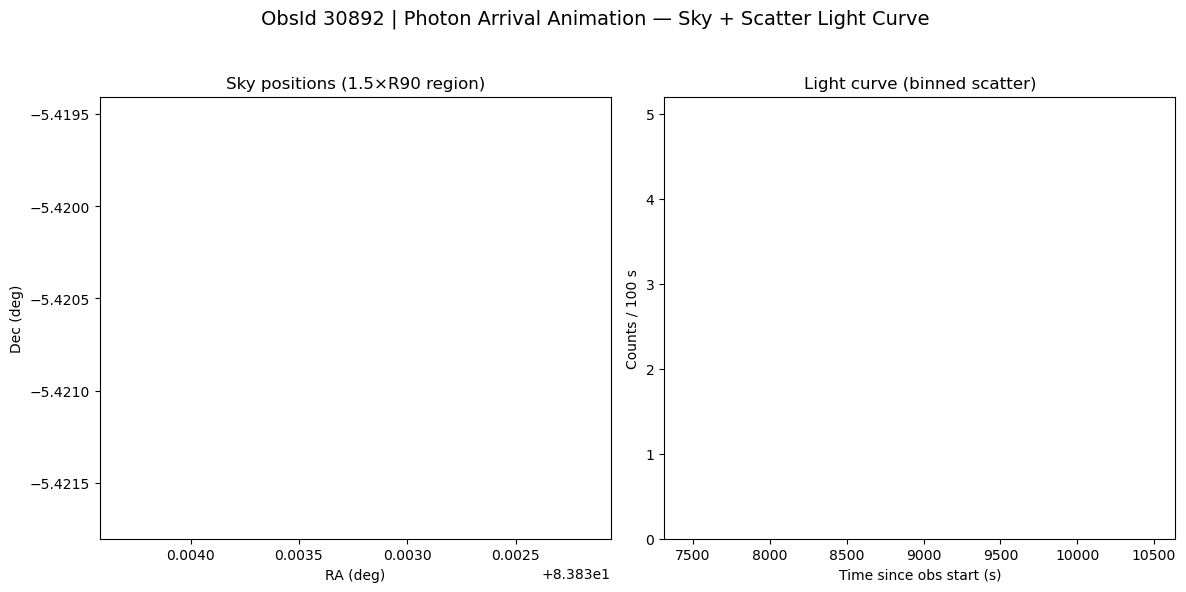

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

# --- Inline animation for Jupyter ---
mpl.rcParams["animation.html"] = "jshtml"

# === Load photon table ===
CSV_PATH = "detections/photon_tables/photons_29128_sig17.386167526245117.csv"
df = pd.read_csv(CSV_PATH).sort_values("Time_s_since_obs_start").reset_index(drop=True)
print(f"Loaded {len(df)} photons")

# === Define time bins ===
binsize = 100.0  # seconds
tmin, tmax = df["Time_s_since_obs_start"].min(), df["Time_s_since_obs_start"].max()
bins = np.arange(tmin, tmax + binsize, binsize)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# === Figure setup ===
fig, (ax_sky, ax_lc) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("ObsId 30892 | Photon Arrival Animation — Sky + Scatter Light Curve", fontsize=14)

# --- Left: sky plot ---
ax_sky.set_xlabel("RA (deg)")
ax_sky.set_ylabel("Dec (deg)")
ax_sky.set_title("Sky positions (1.5×R90 region)")
ax_sky.invert_xaxis()
pad = 0.001
ax_sky.set_xlim(df["RA_deg"].max() + pad, df["RA_deg"].min() - pad)
ax_sky.set_ylim(df["DEC_deg"].min() - pad, df["DEC_deg"].max() + pad)

scat = ax_sky.scatter([], [], s=60, alpha=0.9)
text_box = ax_sky.text(0.02, 0.97, "", transform=ax_sky.transAxes,
                       ha="left", va="top", fontsize=9, color="black")

# --- Right: scatter light curve ---
ax_lc.set_xlabel("Time since obs start (s)")
ax_lc.set_ylabel(f"Counts / {binsize:.0f} s")
ax_lc.set_title("Light curve (binned scatter)")
ax_lc.set_xlim(tmin - 1*(tmax - tmin), tmax + 1*(tmax - tmin))
ax_lc.set_ylim(0, 1.3 * np.max(np.histogram(df["Time_s_since_obs_start"], bins=bins)[0]))
points = ax_lc.scatter([], [], s=40, color="tab:blue", alpha=1)

# --- Color map for photon energy (optional) ---
if "Energy_keV" in df.columns and np.isfinite(df["Energy_keV"]).any():
    norm = (df["Energy_keV"] - df["Energy_keV"].min()) / max(df["Energy_keV"].max() - df["Energy_keV"].min(), 1e-6)
    colors_all = plt.cm.plasma(norm)
else:
    colors_all = plt.cm.plasma(np.linspace(0, 1, len(df)))

# === Animation functions ===
def init():
    scat.set_offsets(np.empty((0, 2)))
    points.set_offsets(np.empty((0, 2)))
    text_box.set_text("")
    return scat, points, text_box

def update(i):
    # --- Sky panel update ---
    coords = np.column_stack((df.loc[:i, "RA_deg"], df.loc[:i, "DEC_deg"]))
    scat.set_offsets(coords)
    scat.set_color(colors_all[:i+1])
    utc = df.loc[i, "UTC"]
    text_box.set_text(f"Photon {i+1}/{len(df)}\n{utc}")

    # --- Light-curve panel update ---
    times_now = df.loc[:i, "Time_s_since_obs_start"]
    counts_now, _ = np.histogram(times_now, bins=bins)
    coords_lc = np.column_stack((bin_centers, counts_now))
    points.set_offsets(coords_lc)

    return scat, points, text_box

ani = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=len(df), interval=600, blit=False, repeat=False
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
ani.save("detections/photon_arrival_animation_30892.gif", writer="ffmpeg", fps=6, dpi=150)

ani  # 👈 shows inline in Jupyter


Loaded 23 photons from detections/photon_tables/photons_30892_sig11.262083053588867.csv


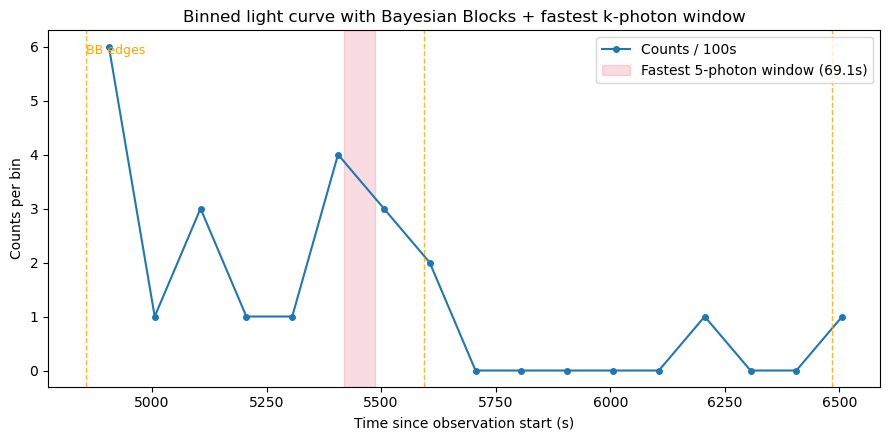


=== Minimal Variability Timescale (single ObsID) ===
Bayesian Blocks MVT     : 736.571 s (2 blocks)
5-photon window MVT   : 69.102 s (from 5418.295s to 5487.397s)


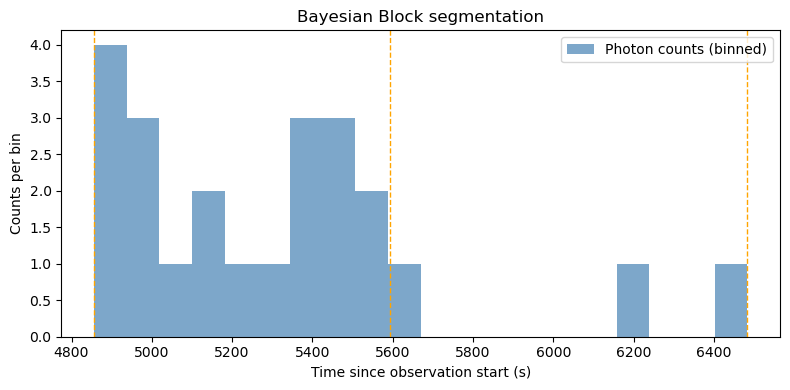

In [50]:
import numpy as np
import pandas as pd
from astropy.stats import bayesian_blocks
import matplotlib.pyplot as plt


# ---------------------------------------
#  Minimal Variability Timescale (single ObsID)
# ---------------------------------------

def mvt_bayesian_blocks(times_s, p0=0.05):
    """
    Estimate minimal variability timescale using Bayesian Blocks.
    Returns (mvt_seconds, block_edges)
    """
    t = np.asarray(times_s, dtype=float)
    if len(t) < 2:
        return np.nan, np.array([])

    edges = bayesian_blocks(t, fitness='events', p0=p0)
    widths = np.diff(edges)
    mvt = np.min(widths) if len(widths) else np.nan
    return mvt, edges

def mvt_n_photon_window(times_s, k=5):
    """
    Estimate minimal timescale as shortest time interval with k photons.
    Returns (mvt_seconds, start_time, end_time)
    """
    t = np.sort(np.asarray(times_s, dtype=float))
    n = len(t)
    if n < k:
        return np.nan, np.nan, np.nan

    dt = t[k-1:] - t[:n-k+1]
    i = np.argmin(dt)
    return dt[i], t[i], t[i + k - 1]

# -------------------------------------------------------
# Load one photon CSV (inside 1.5×R90 region)
# -------------------------------------------------------

csv_path = "detections/photon_tables/photons_30892_sig11.262083053588867.csv"  # <--- change to your file
df = pd.read_csv(csv_path)

print(f"Loaded {len(df)} photons from {csv_path}")

times_s = df["Time_s_since_obs_start"].values

# --- Bayesian Blocks ---
mvt_bb, edges = mvt_bayesian_blocks(times_s, p0=0.05)

# --- N-photon window ---
mvt_k, t0_k, t1_k = mvt_n_photon_window(times_s, k=5)



# inputs you already have:
# times_s = df["Time_s_since_obs_start"].values
# edges    (from bayesian_blocks)
# mvt_k, t0_k, t1_k  (from k-photon window)

binsize = 100.0
tmin, tmax = np.min(times_s), np.max(times_s)
bins = np.arange(tmin, tmax + binsize, binsize)

fig, ax = plt.subplots(1, 1, figsize=(9, 4.5))

# binned light curve (counts/bin)
counts, _ = np.histogram(times_s, bins=bins)
centers = 0.5*(bins[1:] + bins[:-1])
ax.plot(centers, counts, "o-", lw=1.5, ms=4, color="tab:blue", label=f"Counts / {binsize:.0f}s")

# mark Bayesian block edges
for e in edges:
    ax.axvline(e, color="orange", ls="--", lw=1, alpha=0.8)
ax.text(edges[0], ax.get_ylim()[1]*0.93, "BB edges", color="orange", fontsize=9)

# shade the fastest k-photon interval
if np.isfinite(mvt_k):
    ax.axvspan(t0_k, t1_k, color="crimson", alpha=0.15, label=f"Fastest {int(5)}-photon window ({mvt_k:.1f}s)")

ax.set_xlabel("Time since observation start (s)")
ax.set_ylabel("Counts per bin")
ax.set_title("Binned light curve with Bayesian Blocks + fastest k-photon window")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


# --- Print summary ---
print("\n=== Minimal Variability Timescale (single ObsID) ===")
print(f"Bayesian Blocks MVT     : {mvt_bb:.3f} s ({len(edges)-1} blocks)")
print(f"{5}-photon window MVT   : {mvt_k:.3f} s (from {t0_k:.3f}s to {t1_k:.3f}s)")

# Optional: plot diagnostic figure
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(times_s, bins=20, color="steelblue", alpha=0.7, label="Photon counts (binned)")
for e in edges:
    plt.axvline(e, color="orange", ls="--", lw=1)
plt.xlabel("Time since observation start (s)")
plt.ylabel("Counts per bin")
plt.title("Bayesian Block segmentation")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
from astropy.coordinates import get_body, EarthLocation, AltAz, FK5
from astropy.time import Time
import astropy.units as u

# --- 1. Define the date (UTC)
date = "2025-04-08 23:24:21.912"
t = Time(date)

# --- 2. Define observer location (optional, if you just want geocentric coordinates)
# For example, Greenwich Observatory
location = EarthLocation(lat=51.4779*u.deg, lon=0*u.deg, height=46*u.m)

# --- 3. List of planets
planets = ["mercury", "venus", "mars", "jupiter", "saturn", "uranus", "neptune"]

# --- 4. Compute and print RA/Dec
for planet in planets:
    body = get_body(planet, t, location)
    ra = body.ra.to_string(unit=u.hour, sep=':')
    dec = body.dec.to_string(unit=u.deg, sep=':')
    print(f"{planet.capitalize():8s} | RA = {ra:>12s} | Dec = {dec:>12s}")



Mercury  | RA = 23:48:06.73056922 | Dec = -1:45:30.54216954
Venus    | RA = 23:31:22.50844861 | Dec = 2:57:50.86981616
Mars     | RA = 7:54:07.58999661 | Dec = 23:21:45.8867563
Jupiter  | RA = 5:03:16.56943789 | Dec = 22:30:25.5318702
Saturn   | RA = 23:45:01.19135816 | Dec = -3:44:53.63432791
Uranus   | RA = 3:29:56.18366305 | Dec = 18:44:49.14837923
Neptune  | RA = 0:02:00.4696255 | Dec = -1:09:48.59775656


In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import circmean, rayleigh

In [6]:


date = "2025-04-08 23:24:21.912"
t = Time(date)
location = EarthLocation(lat=51.4779*u.deg, lon=0*u.deg, height=46*u.m)

planets = ["mercury", "venus", "mars", "jupiter", "saturn", "uranus", "neptune"]

for planet in planets:
    body = get_body(planet, t, location)
    ra_hms = body.ra.to_string(unit=u.hour, sep=':')
    dec_dms = body.dec.to_string(unit=u.deg, sep=':')
    ra_deg = body.ra.deg
    dec_deg = body.dec.deg
    print(f"{planet.capitalize():8s} | RA = {ra_hms:>12s} ({ra_deg:8.3f}°) | Dec = {dec_dms:>12s} ({dec_deg:+8.3f}°)")


Mercury  | RA = 23:48:06.73056922 ( 357.028°) | Dec = -1:45:30.54216954 (  -1.758°)
Venus    | RA = 23:31:22.50844861 ( 352.844°) | Dec = 2:57:50.86981616 (  +2.964°)
Mars     | RA = 7:54:07.58999661 ( 118.532°) | Dec = 23:21:45.8867563 ( +23.363°)
Jupiter  | RA = 5:03:16.56943789 (  75.819°) | Dec = 22:30:25.5318702 ( +22.507°)
Saturn   | RA = 23:45:01.19135816 ( 356.255°) | Dec = -3:44:53.63432791 (  -3.748°)
Uranus   | RA = 3:29:56.18366305 (  52.484°) | Dec = 18:44:49.14837923 ( +18.747°)
Neptune  | RA = 0:02:00.4696255 (   0.502°) | Dec = -1:09:48.59775656 (  -1.163°)


In [13]:
from astropy.coordinates import get_body, EarthLocation, SkyCoord, ICRS, FK5
from astropy.time import Time
import astropy.units as u

# --- Inputs ---
date = "2025-04-08 23:24:21.912"     # UTC
location = EarthLocation(lat=51.4779*u.deg, lon=0*u.deg, height=46*u.m)  # Greenwich
planets = ["mercury", "venus", "mars", "jupiter", "saturn", "uranus", "neptune"]

# Your J2000/ICRS coordinates (use dot decimal; commas will be handled below if needed)
ra_input = "192.74211"
dec_input = "-6.569637"

target_icrs = SkyCoord(float(ra_input)*u.deg, float(dec_input)*u.deg, frame="icrs")

# Optional: set a "nearby" threshold in degrees
nearby_deg = 5.0

# --- Compute ---
t = Time(date)

print(f"ObsId 30892 (ICRS/J2000): RA={target_icrs.ra.deg:.6f}°, Dec={target_icrs.dec.deg:.6f}°")
print(f"Observing site: {location.lat.deg:.4f}°, {location.lon.deg:.4f}°   Date: {t.isot}\n")
print("Planet     Sep (deg)   Planet J2000 RA (deg)   Dec (deg)    NEAR?")
print("---------------------------------------------------------------")

for name in planets:
    body_apparent = get_body(name, t, location)    # apparent, of-date
    body_icrs = body_apparent.transform_to(ICRS()) # convert to ICRS/J2000 for fair compare
    sep = body_icrs.separation(target_icrs).deg
    near = "◀ within {:.1f}°".format(nearby_deg) if sep <= nearby_deg else ""
    print(f"{name.capitalize():8s}  {sep:9.3f}      {body_icrs.ra.deg:9.3f}       {body_icrs.dec.deg:8.3f}   {near}")



ObsId 30892 (ICRS/J2000): RA=192.742110°, Dec=-6.569637°
Observing site: 51.4779°, 0.0000°   Date: 2025-04-08T23:24:21.912

Planet     Sep (deg)   Planet J2000 RA (deg)   Dec (deg)    NEAR?
---------------------------------------------------------------
Mercury      39.068        230.795        -19.193   
Venus        15.880        208.573         -9.075   
Mars         41.439        155.540         12.111   
Jupiter     107.746         86.218         23.079   
Saturn      158.117        354.067         -4.891   
Uranus      137.750         54.258         19.148   
Neptune     164.912        359.940         -1.451   
